<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  1003 non-null   int64         
 1   title                       1003 non-null   object        
 2   text                        1003 non-null   object        
 3   published_date              1003 non-null   datetime64[ns]
 4   unique_tokens_rate          1003 non-null   float64       
 5   num_hrefs                   1003 non-null   int64         
 6   num_imgs                    1003 non-null   int64         
 7   num_videos                  1003 non-null   int64         
 8   average_token_length        1003 non-null   float64       
 9   num_keywords                1003 non-null   int64         
 10  data_channel                1003 non-null   object        
 11  min_avg_key                 1003 non-null   float64     

,shares
count,1000.000000
mean,4243.046000
std,22641.282639
min,58.000000
25%,1000.000000
50%,1600.000000
75%,3100.000000
max,663600.000000


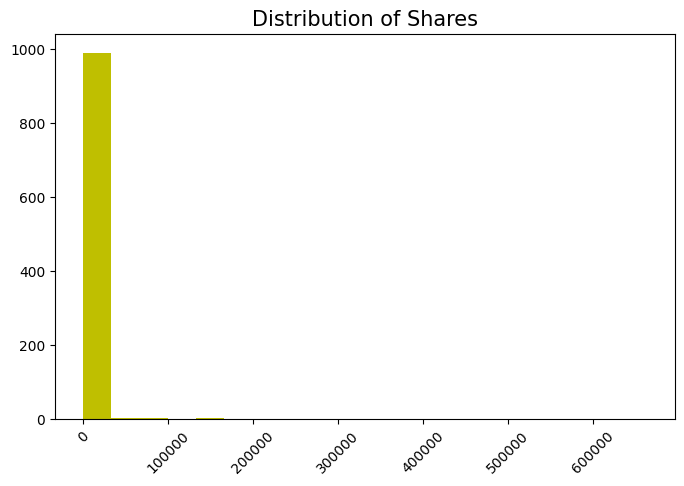

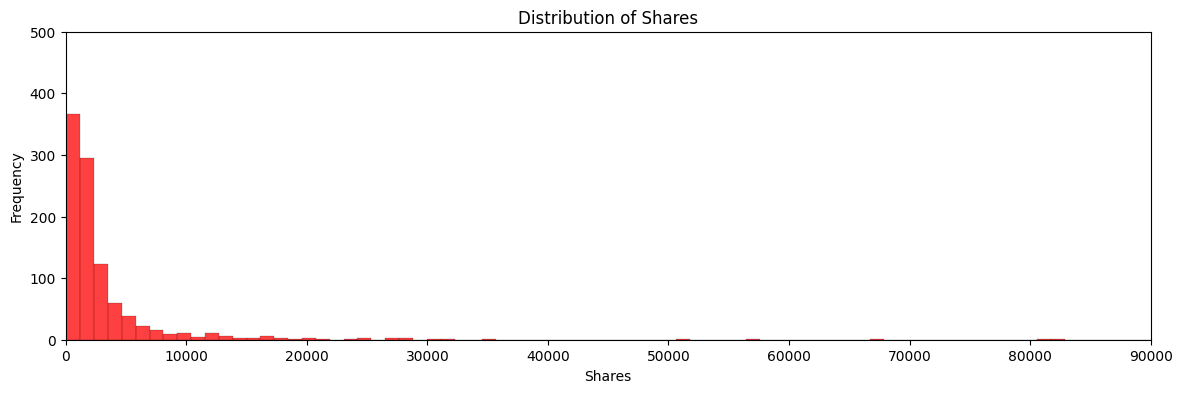

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances



df_test = pd.read_excel("/content/news_share_data.xlsx")
df_test.head()

df_test.columns



df_test.info()

df_test.shape



df_test.isnull().sum()

df_test.duplicated().sum()



df_test = df_test[df_test['title'].apply(lambda x: len(x.split())>4)]
print("Total number of articles after removal of title with short title:", df_test.shape[0])

df_test.shape


df_test.describe()

print("Summary Statistics of Shares:")
display(df_test[['shares']].describe())

plt.figure(figsize=(8,5))
plt.hist(df_test['shares'],bins=20, color = 'y')
plt.title("Distribution of Shares",size=15)
plt.xticks(rotation=45)
plt.show()


array_shares = df_test['shares']

plt.figure(figsize=(14,4))
sns.histplot(array_shares, color = 'r', bins= 577, cbar= True)
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Distribution of Shares')
plt.xlim(0, 90000)  # Set the y-axis limit
plt.ylim(0, 500)  # Set the y-axis limit
plt.show()



df_test['text'].loc[15]


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

def preprocess_text(text):

    text = text.lower()


    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r"'\s+", " ", text)
    text = re.sub(r"\s+'", " ", text)


    text = re.sub(r'[^\w\s]', '', text)


    tokens = word_tokenize(text)


    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]


    cleaned_text = ' '.join(tokens)

    return cleaned_text


df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)
df_test['cleaned_title'] = df_test['title'].apply(preprocess_text)

df_test['cleaned_text'] .loc[15]

df_test['cleaned_title'].loc[15]

weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_test['weekday'] = df_test['published_date'].apply(lambda x: pd.to_datetime(x).day_name())


weekend_names = ['Friday', 'Saturday']


df_test['is_weekend'] = df_test['weekday'].apply(lambda x: 1 if x in weekend_names else 0)


month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_test['month'] = df_test['published_date'].apply(lambda x: month_names[pd.to_datetime(x).month - 1])

df_test.sample(n=5)


df_test['data_channel'].value_counts()


color_scale = px.colors.sequential.Cividis

fig = go.Figure(
    [go.Bar(
        x=df_test["data_channel"].value_counts().index,
        y=df_test["shares"].value_counts().values,
        marker_color=color_scale
    )]
)

fig.update_layout(
    title={"text": 'Distribution of articles Data channel-wise', 'y': 0.9, 'x': 0.5,},
    xaxis_title="Data channel name",
    yaxis_title="Number of articles"
)

fig.update_layout(width=800, height=700)
fig.show()

In [2]:
df_test['cleaned_data_channel'] = df_test['data_channel'].replace('00000', 'Others')
df_test['cleaned_data_channel'].value_counts()


## 4.5 Handling Categorical Data <a name = 'HCD_4.5' ></a>


# Applying one-hot encoding to the 'data_channel' column
enc_cleaned_data_channel = df_test[['cleaned_data_channel']]
enc_cleaned_data_channel = pd.get_dummies(enc_cleaned_data_channel, prefix= 'Channel', drop_first= True)
enc_cleaned_data_channel = enc_cleaned_data_channel.astype(int)
enc_cleaned_data_channel.head()

#concatenating one-hot encoded data channel with main dataframe
df_test = pd.concat([df_test,enc_cleaned_data_channel], axis = 1)
df_test.sample(5)

df_test.columns


Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'cleaned_data_channel',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

In [3]:

df_test['article_id_count'] = df_test.groupby('article_id')['article_id'].transform('count')

duplicate_articles = df_test[df_test['article_id_count'] > 1]

duplicate_articles

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,title_subjectivity,title_sentiment_polarity,shares,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,0.5,0.3,2500,Lifestyle,0,1,0,0,0,2
511,7028680,"Dropbox Unveils Project Harmony, Mailbox for A...",Dropbox on Wednesday unveiled a suite of fresh...,2014-04-09,0.316504,42,11,0,4.540550,7,...,0.3,0.1,2000,Business,0,0,0,0,0,2


In [4]:
df_test = df_test.drop(511, axis=0)
df_test[510:513]

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,title_subjectivity,title_sentiment_polarity,shares,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,0.5,0.3,2500,Lifestyle,0,1,0,0,0,2
512,7028664,Facebook's Not Messing Around: Messenger Will ...,When Facebook acquired standalone messaging ap...,2014-04-09,0.442667,38,30,1,4.902760,7,...,0.0,0.0,1700,Others,0,0,1,0,0,1
513,7028589,Facebook Overhauls and Limits Those Despised R...,When Facebook rolled out its last desktop rede...,2014-04-09,0.608108,6,0,0,4.693694,6,...,0.0,0.0,3700,Tech,0,0,0,0,1,1


In [6]:
cols_to_treat = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']

print("\nDistribution (BEFORE outlier treatment):")
display(df_test[cols_to_treat].describe())


Distribution (BEFORE outlier treatment):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.527192,11.706707,5.156156,1.219219,4.604425,7.207207,1132.205907,6427.349984,3355.117077,13554.811749,0.446645,0.106056,0.038137,0.017789,0.293408,0.057666,4245.291291
std,0.118711,15.177740,8.452842,4.087347,0.703038,1.859846,1181.656104,7345.282277,1456.857126,51598.155938,0.109343,0.092590,0.015668,0.010574,0.325482,0.267121,22652.511740
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.000000,-0.300000,0.000000,0.000000,0.000000,-1.000000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.867925,162.000000,84.000000,51.000000,7.218430,10.000000,3613.040000,102200.000000,17604.270000,663600.000000,0.875000,0.489623,0.120805,0.103030,1.000000,1.000000,663600.000000



Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.532183,10.158158,4.260260,0.547548,4.675496,7.207207,1132.205907,5499.373117,3256.800153,4976.071248,0.450364,0.106496,0.037962,0.017433,0.293408,0.056851,2366.762763
std,0.099346,7.654816,5.105337,0.807028,0.284113,1.859846,1181.656104,2231.951378,1047.739362,5258.348719,0.091591,0.087908,0.014989,0.009358,0.325482,0.170974,1812.447026
min,0.272165,0.000000,0.000000,0.000000,3.942951,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224646,-0.114407,0.001300,0.000000,0.000000,-0.225000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.791285,29.000000,16.000000,2.500000,5.404047,10.000000,3613.040000,10985.215000,5720.423500,16402.500000,0.680424,0.329107,0.074246,0.039680,1.000000,0.375000,6250.000000


unique_tokens_rate            float64
num_hrefs                       int64
num_imgs                        int64
num_videos                    float64
average_token_length          float64
num_keywords                    int64
min_avg_key                   float64
max_avg_key                   float64
avg_avg_key                   float64
href_avg_shares               float64
global_subjectivity           float64
global_sentiment_polarity     float64
global_rate_positive_words    float64
global_rate_negative_words    float64
title_subjectivity            float64
title_sentiment_polarity      float64
shares                          int64
dtype: object


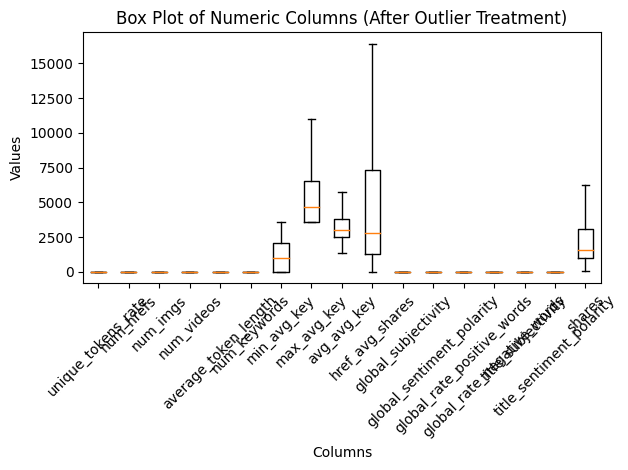

In [7]:
# Outlier treatment using IQR method
def treat_outliers_iqr(df_test, col):
    q1 = df_test[col].quantile(0.25)
    q3 = df_test[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_test[col] = df_test[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return df_test

for col in cols_to_treat:
    df_test = treat_outliers_iqr(df_test, col)

print("\nDistribution (after outlier treatment using IQR method):")
display(df_test[cols_to_treat].describe())


print(df_test[cols_to_treat].dtypes)


import matplotlib.pyplot as plt

plt.boxplot(df_test[cols_to_treat])

plt.xticks(range(1, len(cols_to_treat) + 1), cols_to_treat, rotation=45)

plt.title('Box Plot of Numeric Columns (After Outlier Treatment)')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [14]:
df_test.isnull().sum()

unique_tokens_rate            0
num_hrefs                     0
num_imgs                      0
num_videos                    0
average_token_length          0
num_keywords                  0
min_avg_key                   0
max_avg_key                   0
avg_avg_key                   0
href_avg_shares               0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
title_subjectivity            0
title_sentiment_polarity      0
shares                        0
cleaned_data_channel          0
Channel_Entertainment         0
Channel_Lifestyle             0
Channel_Others                0
Channel_Social Media          0
Channel_Tech                  0
article_id_count              0
dtype: int64

In [19]:
df_test.shape

(999, 24)